In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.optimize import curve_fit
from sklearn.cluster import DBSCAN, OPTICS, AgglomerativeClustering
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from pathlib import Path
import matplotlib as mpl
from matplotlib import cm
import matplotlib.colors as colors
import matplotlib.cbook as cbook
import time
import sys
import multiprocessing as mp
from scipy.stats import moyal
import os

def landaufunc(x,C,mu,scale):
    return C*moyal.pdf(x, mu, scale)

def gaussian(x, C, mu, sigma):
    return C*np.exp(-np.power(x - mu, 2.) / (2 * np.power(sigma, 2.)))

SET_N_TRHEADS = 4

# Cluster generation

In [2]:
def makeCluster(wx, wy, npix, nclusters = 1):
    cluster=[]
    total_area=0
    for nc in range(nclusters):
        x = np.random.normal(0, wx, npix*5)
        y = np.random.normal(0, wy, npix*5)
        cx = np.random.randint(int(wx*5), 1023-int(wx*5))
        cy = np.random.randint(int(wy*5),  511-int(wy*5))
        angle = np.random.uniform(0, np.pi, 1)
        xr = x*np.cos(angle)+y*np.sin(angle)+cx
        yr = y*np.cos(angle)-x*np.sin(angle)+cy
        x = xr.astype(int)
        y = yr.astype(int)
        
        k = 0
        for i in range(len(x)):
            if ([x[i],y[i]]) not in cluster:
                k+=1
                cluster.append([x[i],y[i]])
        if k == 1: #delete cluster with area 1
            cluster.pop()
        else:
            total_area+=k
        
    return cluster, total_area 

def makeNoise(Noise_points):
    noise=[]
    for i in range(Noise_points):
        nx = np.random.randint(0,1024)
        ny = np.random.randint(0, 512)
        noise.append([nx,ny])
        
    return noise

def makeRealCluster(wx, wy, npix, nclusters = 1, Noise_points=0):
    cluster, total_area= makeCluster(wx, wy, npix, nclusters)
    if Noise_points != 0:
        noise = makeNoise(Noise_points)
        realcluster=np.append(cluster,noise,axis=0)
    else:
        realcluster = cluster
    return realcluster, total_area

# Clustering algorithm

In [15]:
#DBSCAN
#Very good noise discrimination, if noise is high (10 noise points per probe cluster)
#Good cluster discrimination
#Higher time consuption over Agglomerative clustering
#Can be prarallelized
def findClusterDB(X, distance):
    if len(X)>1:
        db = DBSCAN(eps=distance, min_samples=2).fit(X)
        clusters = np.column_stack((X, db.labels_))
        nc = np.sum(clusters[:,2]==-1)
        Noise_inds=np.where(clusters[:,2]==-1)
        clusters=np.delete(clusters,Noise_inds,axis=0)
        labels=np.delete(db.labels_,Noise_inds,axis=0)
        unique, Areas = np.unique(labels, return_counts=True)
    elif len(X)==1:
        clusters=np.reshape([],(0,3))
        Areas=[]
        nc=1
    else:
        clusters=np.reshape([],(0,3))
        Areas=[]
        nc=0

    return clusters, Areas, nc

#Agglomerative clustering
#Good noise discrimination with few noise points per probed cluster(upto 2)
#Poor noise discrimination with more noise points per probed cluster(over 4)
#Cluster discrimination depends on noise density
#Lower time consuption over DBSCAN (1/3 factor)
#Parallelization fails if packets with 0 or 1 points are present
def findClusterAgg(X, distance):
    if len(X)>1:
        agg = AgglomerativeClustering(n_clusters=None, distance_threshold=distance, compute_full_tree=True).fit(X)
        clusters = np.column_stack((X, agg.labels_))
        unique, Areas = np.unique(agg.labels_, return_counts=True)
        Noise_inds=[]
        Area_noise_inds=np.array(np.where(Areas==1))
        if len(Area_noise_inds[0]) != 0:
            for index in Area_noise_inds[0]:
                Current_index=np.array(np.where(clusters[:,2]==index))
                Noise_inds=np.append(Noise_inds,Current_index)
            Noise_inds=Noise_inds.astype(int)
            nc=len(Area_noise_inds[0])
            clusters=np.delete(clusters,Noise_inds,axis=0)
            labels=np.delete(agg.labels_,Noise_inds,axis=0)
            unique, Areas = np.unique(labels, return_counts=True)
        else:
            nc=0
    elif len(X)==1:
        clusters=np.reshape([],(0,3))
        Areas=[]
        nc=1
    else:
        clusters=np.reshape([],(0,3))
        Areas=[]
        nc=0
    
    return clusters, Areas, nc

#Poor everything, like third world        
def findClusterOPTICS(X, distance):
    opt = OPTICS(eps=distance, min_samples=2, n_jobs=1).fit(X)
    clusters = np.column_stack((X, opt.labels_))
    unique, Areas = np.unique(clusters, return_counts=True)
    nc = np.sum(clusters[:,2]==-1)
     
    return clusters, Areas, nc

# PCA analysis, cluster mean and cosmic discrimination

In [4]:
class ACluster(): #analyzed cluster
    def __init__(self,mean,pca_r,area):
        self.mean=mean #Cluster centroind
        self.pca_r=pca_r#Principal axis variance ratio
        self.area=area #Cluster area
        
def ClusterAnalysisPCA(Cluster):
    pca = PCA(n_components=2)
    pca.fit(Cluster)
    mean=np.array(pca.mean_)
    if pca.explained_variance_ratio_[1]!=0 and pca.explained_variance_ratio_[0]!=0:
        pca_r=min(10.0,(pca.explained_variance_ratio_[0]/pca.explained_variance_ratio_[1]))
    else:
        pca_r=10.0
    area=len(Cluster)
    CC=ACluster(mean,pca_r,area)
    
    return CC
    

# Function parallelized

In [5]:
def par_findClusterDB(Total_packet,distance):
    input_data=[]
    nc_plus=0
    for packet in Total_packet:
        cd=(packet,distance)
        input_data.append(cd)

    pDB=mp.Pool(processes=SET_N_TRHEADS)
    DBresult= pDB.starmap(findClusterDB,input_data)
    pDB.close()
    pDB.join()
    
    
    return DBresult, nc_plus

def par_findClusterAgg(Total_packet,distance):
    input_data=[]
    for packet in Total_packet:
        cd=(packet,distance,)
        input_data.append(cd)

    pAgg=mp.Pool(processes=SET_N_TRHEADS)
    Aggresult= pAgg.starmap(findClusterAgg,input_data)
    pAgg.close()
    pAgg.join()
    
    
    
    return Aggresult

def par_ClusterAnalysisPCA(parallel_result):
    input_data=[]
    for partial_res in parallel_result:
        unique_labels=np.unique(partial_res[0][:,2], return_counts=False)
        for label in unique_labels:
                Index=np.where(partial_res[0][:,2]==label)
                C=partial_res[0][Index]
                cd=(C[:,:2],)#components with selected label
                input_data.append(cd)
                
    pPCA=mp.Pool(processes=SET_N_TRHEADS)            
    PCAresult=pPCA.starmap(ClusterAnalysisPCA,input_data)
    pPCA.close()
    pPCA.join()
    
   
    
    return PCAresult


# Test clusters generation

Text(0, 0.5, 'Row')

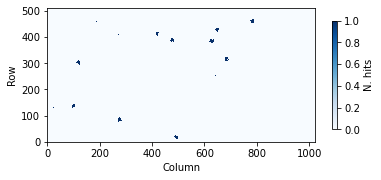

In [6]:
real, tot_area=makeRealCluster(3,3,100,10,100)


#generate the hitmap
cluster_matrix=np.zeros((512,1024))
for pixel in real:
    x=pixel[0]
    y=pixel[1]
    cluster_matrix[y,x] += 1

#and plot it
fig, ax = plt.subplots()
colormap = cm.get_cmap('Blues')
psm = ax.pcolormesh(cluster_matrix, cmap=colormap, vmin=0, vmax=np.max(cluster_matrix))
cbar=plt.colorbar(psm, shrink=0.5, ax=ax)
cbar.set_label("N. hits")
plt.axis('scaled')
ax.set(xlim=(0, 1023), ylim=(0, 511))
plt.xlabel("Column")
plt.ylabel("Row")

# Packet decoder simulation with DBSCAN

Completeness : 99.0%
Noise points injected:  7231
Noise points found:  7210
Execution time:  3.638172149658203
Exact area:  30.641952651862727
Mean area:  30.70779698418536
Missclassified:  0.3119838502477519 %


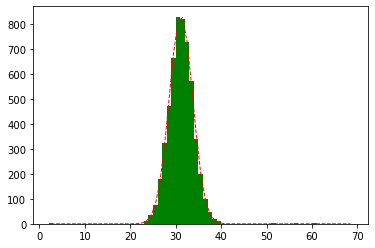

In [27]:
N=1000
patience = 10
#npp=10#noise ponits per packet
Areas=[]
t = time.time()
Tot_area_sim=0
Tot_clusters=0
Tot_noise=0
Np_inj=0
tot_clust_inj = 0
tot_missclass = 0

for i in range(N):
    if ( i % patience == 0 ):
        sys.stdout.write("\rCompleteness : "+str(round(i/N*100,1))+"%")
    Nclusters=np.random.randint(1,11)
    npp=np.random.randint(1,15)#noise ponits per packet
    Np_inj+=npp
    realPacket, Area_sim=makeRealCluster(1,2,15,Nclusters,npp)
    Tot_area_sim+=Area_sim
    Tot_clusters+=Nclusters
    Cluster, AreaCluster, nc=findClusterDB(realPacket,5)
    Areas=np.append(Areas,AreaCluster)
    tot_missclass += np.abs(len(np.unique(Cluster[:,2])) - Nclusters)
    tot_clust_inj += Nclusters
    Tot_noise+=nc

n, bins, patches = plt.hist(Areas, int(np.max(Areas)-np.min(Areas)), facecolor='g')
b=np.delete(bins,-1)+(np.mean(0.5*(np.delete(bins,0)-np.delete(bins,-1))))
popt, pcov = curve_fit(gaussian, xdata=b, ydata=n, p0=[len(Areas), np.mean(Areas), np.std(Areas)])
plt.plot(b, gaussian(b,popt[0],popt[1],popt[2]), 'r--', linewidth=1)

print("")
print("Noise points injected: ", Np_inj)
print("Noise points found: ", Tot_noise)
print("Execution time: ", time.time()-t)
print("Exact area: ", Tot_area_sim/Tot_clusters)
print("Mean area: ", np.mean(Areas))
print("Missclassified: ", tot_missclass/tot_clust_inj*100, "%")

In [6]:
np.max(Areas)

59.0

[0 1 2 3 4]


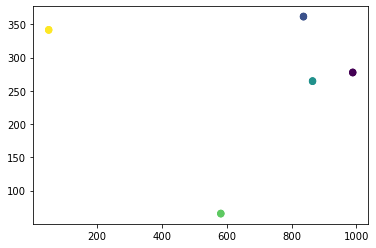

In [7]:
Npackets=np.random.randint(1,10)
clust, Area_sim=makeCluster(0.1,0.1,15,Npackets)
ClusterDC, AreaCluster, _=findClusterDB(clust,1)
plt.scatter(ClusterDC[:,0], ClusterDC[:,1], c=ClusterDC[:,2])

print(np.unique(ClusterDC[:,2]))

# Packet decoder simulation with Agglomerative Clustering

Completeness : 99.0%
Noise points injected:  7598
Noise points found:  7275
Execution time:  3.3435962200164795
Exact area:  30.67255659856433
Mean area:  30.11127141568981
Missclassified:  2.0982882385422417 %


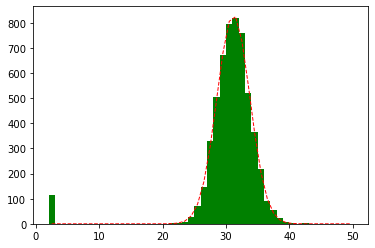

In [30]:
N=1000
patience = 10
Areas=[]
t = time.time()
Tot_area_sim=0
Tot_clusters=0
Tot_noise=0
tot_clust_inj = 0
Np_inj=0
tot_missclass = 0

for i in range(N):
    if ( i % patience == 0 ):
        sys.stdout.write("\rCompleteness : "+str(round(i/N*100,1))+"%")
    Nclusters=np.random.randint(1,11)
    npp=np.random.randint(1,15)#noise ponits per packet
    Np_inj+=npp
    realPacket, Area_sim=makeRealCluster(1,2,15,Nclusters,npp)
    Tot_area_sim+=Area_sim
    Tot_clusters+=Nclusters
    Cluster, AreaCluster, nc=findClusterAgg(realPacket,25)
    Areas=np.append(Areas,AreaCluster)
    tot_missclass += np.abs(len(np.unique(Cluster[:,2])) - Nclusters)
    tot_clust_inj += Nclusters
    Tot_noise+=nc  

n, bins, patches = plt.hist(Areas, int(np.max(Areas)-np.min(Areas)), facecolor='g')
b=np.delete(bins,-1)+(np.mean(0.5*(np.delete(bins,0)-np.delete(bins,-1))))
popt, pcov = curve_fit(gaussian, xdata=b, ydata=n, p0=[len(Areas), np.mean(Areas), np.std(Areas)])
plt.plot(b, gaussian(b,popt[0],popt[1],popt[2]), 'r--', linewidth=1)

print("")
print("Noise points injected: ", Np_inj)
print("Noise points found: ", Tot_noise)
print("Execution time: ", time.time()-t)
print("Exact area: ", Tot_area_sim/Tot_clusters)
print("Mean area: ", np.mean(Areas))
print("Missclassified: ", tot_missclass/tot_clust_inj*100, "%")

[0 1 2 3 4]


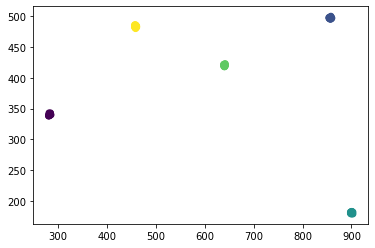

In [9]:
Npackets=5#np.random.randint(5,10)
clust, Area_sim=makeCluster(1,1,15,Npackets)
noise=makeNoise(10)
realclust=np.append(clust,noise,axis=0)
ClusterDC, AreaCluster, _=findClusterAgg(realclust,10)
plt.scatter(ClusterDC[:,0], ClusterDC[:,1], c=ClusterDC[:,2])

print(np.unique(ClusterDC[:,2]))

In [10]:
#LENTOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO

#N=10000
#patience = 10
#Areas=[]
#t = time.time()
#
#for i in range(N):
#    if ( i % patience == 0 ):
#        sys.stdout.write("\rCompleteness : "+str(round(i/N*100,1))+"%")
#    Npackets=np.random.randint(5,10)
#    clust=makeCluster(3,6,15,4,Npackets)
#    ClusterDC, AreaCluster, _=findClusterOPTICS(clust,10)
#    Areas=np.append(Areas,AreaCluster)
#
#print("")  
#print(time.time()-t)
#print(np.mean(Areas))

# ALPIDE data test and clustering comparisons

In [6]:
Folder_name="DC_ALPIDE_20h_data"
i=0
ClusterDB=[]
AreaClusterDB=[]
ncDB=0
DataDB=[]
DataDB_par=[]
ClusterAgg=[]
AreaClusterAgg=[]
ncAgg=0
DataAgg=[]
Par_time=0
Ser_time=0
#while i<20:
while True:
    file_name=Folder_name+"/"+Folder_name+"_packet_{0:0d}.npy".format(i)
    my_file = Path(file_name)
    if my_file.is_file():
        i += 1
        packet = np.load(file_name, allow_pickle=True)
        t=time.time()
        DBresult, nc_not_counted=par_findClusterDB(packet,1)
        PCAresult=par_ClusterAnalysisPCA(DBresult)
        DataDB_par=np.append(DataDB_par,PCAresult)
        ncDB+=sum(data[2] for data in DBresult)
        Par_time+=time.time()-t
        #t=time.time()
        #for current_packet in packet:
            #Cluster, AreaCluster, nc = findClusterDB(current_packet,1)
            #for k in range(len(AreaCluster)):
                #Index=np.where(Cluster[:,2]==k)
                #C=Cluster[Index]
                #CC=ClusterAnalysisPCA(C[:,:2])
                #DataDB.append(CC)
            #ncDB+=nc
        #Ser_time+=time.time()-t
    else:
        print ("No more packets to analyze")
        break
        
print("Parallelized function time =", Par_time)
#print("Standard function =", Ser_time)
areasDB=np.array([d.area for d in DataDB_par])
ratiosDB=np.array([d.pca_r for d in DataDB_par])
meansDB=np.array([d.mean for d in DataDB_par])
print("Estimated noise points=",ncDB)
print("Estimated clusters=",len(areasDB))
print("Estimated mean area=",np.mean(areasDB))

No more packets to analyze
Parallelized function time = 2100.8716542720795
Estimated noise points= 980319
Estimated clusters= 8845372
Estimated mean area= 19.784252149033417


In [8]:
i

4

In [23]:
Folder_name="DC_ALPIDE_20h_data"
i=0
ClusterAgg=[]
AreaClusterAgg=[]
ncAgg=0
DataAgg=[]
Ser_time=0
while True:
#while i<20:
    file_name=Folder_name+"/"+Folder_name+"_packet_{0:0d}.npy".format(i)
    my_file = Path(file_name)
    if my_file.is_file():
        i += 1
        packet = np.load(file_name, allow_pickle=True)
        t=time.time()
        for current_packet in packet:
            if len(current_packet)>1:
                Cluster, AreaCluster, nc = findClusterAgg(current_packet,15)
                for k in range(len(AreaCluster)): 
                    Index=np.where(Cluster[:,2]==k)
                    C=Cluster[Index]
                    if len(C)!=0:
                        CC=ClusterAnalysisPCA(C[:,:2])
                        DataAgg.append(CC)
                ncAgg+=nc
            elif len(current_packet)==1:
                ncAgg+=1
        Ser_time+=time.time()-t
    else:
        print ("No more packets to analyze")
        break
        
print(Ser_time)
areasAgg=np.array([d.area for d in DataAgg])
ratiosAgg=np.array([d.pca_r for d in DataAgg])
meansAgg=np.array([d.mean for d in DataAgg])
print("Estimated noise points=",ncAgg)
print("Estimated clusters=",len(DataAgg))
print("Estimated mean area=",np.mean(areasAgg))

No more packets to analyze
4014.9031496047974
Estimated noise points= 455559
Estimated clusters= 8765650
Estimated mean area= 20.02404944299624


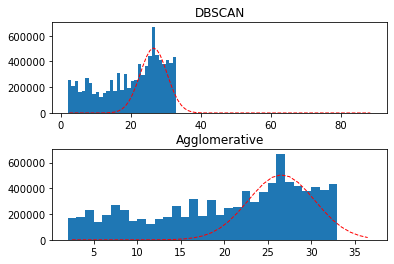

In [24]:
plt.subplot(211)
plt.subplots_adjust(hspace = 0.4)
plt.title("DBSCAN")
n,bins,patches=plt.hist(areasDB,bins=int(np.max(areasDB)-np.min(areasDB)),range=(np.min(areasDB),np.max(areasDB)))
b=np.delete(bins,-1)+(np.mean(0.5*(np.delete(bins,0)-np.delete(bins,-1))))
popt, pcov = curve_fit(gaussian, xdata=b[range(np.argmax(n)-4,np.argmax(n)+4,1)], 
                       ydata=n[range(np.argmax(n)-4,np.argmax(n)+4,1)], p0=[np.max(areasDB), np.mean(areasDB), np.std(areasDB)])
plt.plot(b, gaussian(b,popt[0],popt[1],popt[2]), 'r--', linewidth=1)
plt.subplot(212)
plt.title("Agglomerative")
n,bins,patches=plt.hist(areasAgg,bins=int(np.max(areasAgg)-np.min(areasAgg)),range=(np.min(areasAgg),np.max(areasAgg)))
b=np.delete(bins,-1)+(np.mean(0.5*(np.delete(bins,0)-np.delete(bins,-1))))
popt, pcov = curve_fit(gaussian, xdata=b[range(np.argmax(n)-4,np.argmax(n)+4,1)], 
                       ydata=n[range(np.argmax(n)-4,np.argmax(n)+4,1)], p0=[np.max(areasAgg), np.mean(areasAgg), np.std(areasAgg)])
plt.plot(b, gaussian(b,popt[0],popt[1],popt[2]), 'r--', linewidth=1)

# Discrimination (area too small and PCA ratio too large)

In [36]:
Area_discrimination=5
Ratio_discrimination=3

a_disc_index=np.where(areasDB <=Area_discrimination)
r_disc_index=np.where(ratiosDB >=Ratio_discrimination)
disc_index=np.unique(np.append(a_disc_index,r_disc_index))
DataDB_alpha=np.delete(DataDB_par,disc_index)

areasDB_alpha=np.array([d.area for d in DataDB_alpha])
ratiosDB_alpha=np.array([d.pca_r for d in DataDB_alpha])
meansDB_alpha=np.array([d.mean for d in DataDB_alpha])

a_disc_index=np.where(areasAgg <=Area_discrimination)
r_disc_index=np.where(ratiosAgg >=Ratio_discrimination)
disc_index=np.unique(np.append(a_disc_index,r_disc_index))
DataAgg_alpha=np.delete(DataAgg,disc_index)

areasAgg_alpha=np.array([d.area for d in DataAgg_alpha])
ratiosAgg_alpha=np.array([d.pca_r for d in DataAgg_alpha])
meansAgg_alpha=np.array([d.mean for d in DataAgg_alpha])

# X

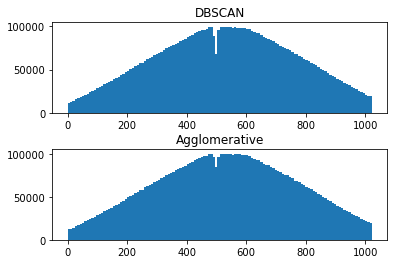

In [37]:
plt.subplot(211)
plt.subplots_adjust(hspace = 0.4)
plt.title("DBSCAN")
n,bins,patches=plt.hist(meansDB_alpha[:,1],128)
plt.subplot(212)
plt.title("Agglomerative")
n,bins,patches=plt.hist(meansAgg_alpha[:,1],128)


# 2D Histo

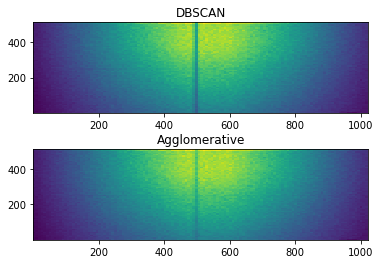

Done


In [38]:
plt.subplot(211)
plt.subplots_adjust(hspace = 0.4)
plt.title("DBSCAN")
plt.hist2d(meansDB_alpha[:,1],meansDB_alpha[:,0],[128,64])
plt.subplot(212)
plt.title("Agglomerative")
plt.hist2d(meansAgg_alpha[:,1],meansAgg_alpha[:,0],[128,64])
plt.show()
print("Done")

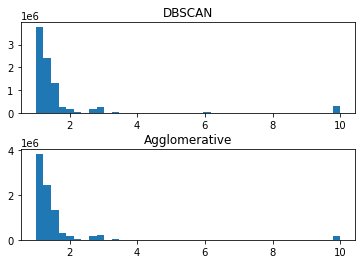

In [29]:
plt.subplot(211)
plt.subplots_adjust(hspace = 0.4)
plt.title("DBSCAN")
n,bins,patches=plt.hist(ratiosDB,40)
plt.subplot(212)
plt.title("Agglomerative")
n,bins,patches=plt.hist(ratiosAgg,40)

Text(0, 0.5, 'Row')

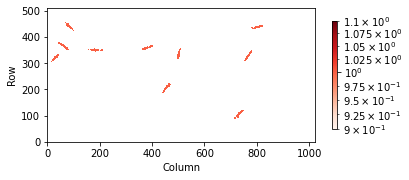

In [24]:
N=100
npp=10
        
Data=[]

for k in range(N):
    Nclusters=10
    Packet, Area_sim=makeCluster(1.5,10,10,Nclusters)
    noise=makeNoise(npp)
    realPacket=np.append(Packet,noise,axis=0)
    Cluster, AreaCluster, nc=findClusterDB(realPacket,7)
    for i in range(len(AreaCluster)):
        Index=np.where(Cluster[:,2]==i)
        C=Cluster[Index]
        CC=ClusterAnalysisPCA(C[:,:2])
        Data.append(CC)

    
#generate the hitmap
cluster_matrix=np.zeros((512,1024))
for pixel in Cluster[:,:2]:
    x=pixel[0]
    y=pixel[1]
    cluster_matrix[y,x] += 1

#and plot it
fig, ax = plt.subplots()
colormap = cm.get_cmap('Reds')
psm = ax.pcolormesh(cluster_matrix, cmap=colormap, norm=colors.LogNorm(), vmin=1, vmax=np.max(cluster_matrix))
cbar=plt.colorbar(psm, shrink=0.5, ax=ax)
#cbar.set_label("N. hits")
plt.axis('scaled')
ax.set(xlim=(0, 1023), ylim=(0, 511))
plt.xlabel("Column")
plt.ylabel("Row")

# Test with real data

PCA_ratio= :2.4449249531025052 +/- 2.2026223047275173 
Area= :5.947318007662835 +/- 4.302287381726502 


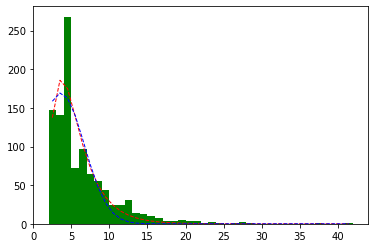

In [14]:
XPacket=np.load("Test_data/X.npy")
X2Packet=np.load("Test_data/X2.npy")
ePacket=np.load("Test_data/electron.npy")
aPacket=np.load("Test_data/alpha.npy")
cPacket=np.load("Test_data/cosmic_ray.npy")


Packet=cPacket
Flag_alpha=False
Data=[]
for row in range(512):
    for column in range(1024):
        if Packet[row,column] > 0:
            Data.append([row,column])
            
Cluster, AreaCluster, nc=findClusterDB(Data,1)


#routine to delete overlapping clusters (only present in alpha packet)
THR_index=np.array(np.where(AreaCluster>80))
C_index=[]
if len(THR_index[0]) != 0:
        for index in THR_index[0]:
            Current_index=np.array(np.where(Cluster[:,2]==index))
            C_index=np.append(C_index,Current_index)
        C_index=C_index.astype(int)
        Cluster=np.delete(Cluster,C_index,axis=0)

unique_index = np.unique(Cluster[:,2], return_counts=False)
Data_a=[]

for i in unique_index:
    Index=(np.where(Cluster[:,2]==i))
    C=Cluster[Index]
    CC=ClusterAnalysisPCA(C[:,:2],AreaCluster[i])
    Data_a.append(CC) 

#Need to find better way to get the parameters 
pcaratio=[]
NewArea=[]
for j in range(len(Data_a)):
    NewArea.append(Data_a[j].area)
    if Data_a[j].pca_r !=1000:
        pcaratio.append(Data_a[j].pca_r)
        
n, bins, patches = plt.hist(NewArea, int(np.max(NewArea)-np.min(NewArea)), facecolor='g')
b=np.delete(bins,-1)+(np.mean(0.5*(np.delete(bins,0)-np.delete(bins,-1))))

if not Flag_alpha :
    popt_l, pcov_l = curve_fit(landaufunc, xdata=b, ydata=n)
    popt_g, pcov_g = curve_fit(gaussian, xdata=b, ydata=n, p0=[200,np.mean(NewArea),np.std(NewArea)])
#popt, pcov = curve_fit(doublegauss, xdata=b, ydata=n, p0=[300,100,4,15,3,5])
#popt, pcov = curve_fit(gaussian, xdata=b, ydata=n)
else:
    popt, pcov = curve_fit(landaufunc, xdata=b[(range(11,19,1))], ydata=n[(range(11,19,1))])
#plt.plot(b, gaussian(b,popt[0],popt[1],popt[2]), 'r--', linewidth=1)   
plt.plot(b, landaufunc(b,popt_l[0],popt_l[1],popt_l[2]), 'r--', linewidth=1)
plt.plot(b, gaussian(b,popt_g[0],popt_g[1],popt_g[2]), 'b--', linewidth=1)


print("PCA_ratio= :{} +/- {} ".format(np.mean(pcaratio), np.std(pcaratio)))
print("Area= :{} +/- {} ".format(np.mean(NewArea), np.std(NewArea)))


           


# Multiprocessing test

In [17]:
Folder_name="Test_data"
i=0
Packet_tot=[]
file_name=Folder_name+"/"+Folder_name+"_packet_{0:0d}.npy".format(i)
Packet= np.load(file_name, allow_pickle=True)
for i in range(4):
    Packet_tot=np.append(Packet_tot,Packet)
print(len(Packet_tot))

107572


In [8]:
N=100000
npp=10
patience=10
Packet_tot=[]
Nclusters=10
for i in range(N):
    if ( i % patience == 0 ):
        sys.stdout.write("\rCompleteness : "+str(round(i/N*100,1))+"%")
    Packet, Area_sim=makeCluster(1,2,20,Nclusters)
    noise=makeNoise(npp)
    realPacket=np.append(Packet,noise,axis=0)
    Packet_tot.append(realPacket)

Completeness : 100.0%

In [20]:
t=time.time()
Data=[]
for packet in Packet_tot:
    if len(packet)>1:
        Cluster, AreaCluster, nc=findClusterDB(packet,1)
        for i in range(len(AreaCluster)):
                Index=np.where(Cluster[:,2]==i)
                C=Cluster[Index]
                CC=ClusterAnalysisPCA(C[:,:2])
                Data.append(CC)
            
Serial_t=time.time()-t
print('Completion time with serial processing :',Serial_t)

Completion time with serial processing : 20.326613426208496


In [19]:
t=time.time()
Data=[]
for packet in Packet_tot:
    if len(packet)>1:
        Cluster, AreaCluster, nc=findClusterAgg(packet,7)
        for i in range(len(AreaCluster)):
                Index=np.where(Cluster[:,2]==i)
                C=Cluster[Index]
                CC=ClusterAnalysisPCA(C[:,:2])
                Data.append(CC)

            
Serial_t=time.time()-t
print('Completion time with serial processing :',Serial_t)

Completion time with serial processing : 14.853801250457764


In [21]:
t=time.time()
DBresult=par_findClusterDB(Packet_tot,7)
Clustering_time=time.time()-t
print('Clustering time with parallel processing :',Clustering_time)

t=time.time()
PCAresult=par_ClusterAnalysisPCA(DBresult)
Alaysis_time=time.time()-t
print('Analysis time with parallel processing :',Alaysis_time)
print('Total time with parallel processing :',Clustering_time+Alaysis_time)

Clustering time with parallel processing : 18.52030110359192
Analysis time with parallel processing : 3.1339871883392334
Total time with parallel processing : 21.654288291931152


(array([750., 732., 854., 794., 799., 810., 768., 818., 832., 855.]),
 array([5.0000e-01, 5.1550e+01, 1.0260e+02, 1.5365e+02, 2.0470e+02,
        2.5575e+02, 3.0680e+02, 3.5785e+02, 4.0890e+02, 4.5995e+02,
        5.1100e+02]),
 <a list of 10 Patch objects>)

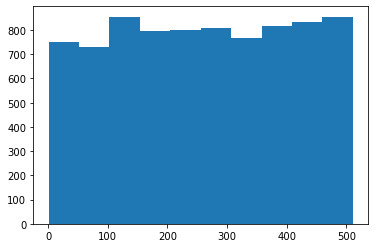

In [37]:
areas=np.array([d.area for d in Data])
ratios=np.array([d.pca_r for d in Data])
means=np.array([d.mean for d in Data])
plt.hist(means[:,0])

72